# Tile processing accross multiple devices

In this notebook we will process a big dataset that has been saved in zarr format to count cells in individual tiles accross the different available devices of our system. For every tile, we will fetch a device, load the tile in it, process it to get the number of cell, and write the number in a pixel of an output image. Hence, we are producing a cell-count image that is smaller than the original image by a factor that corresponds to the tile size.

In [1]:
import skimage
import zarr
import os
import shutil
import gc

import pyclesperanto as cle
import numpy as np
import dask.array as da
from functools import partial

from skimage import io, filters, measure, morphology
from numcodecs import Blosc

For demonstration purposes, we use a dataset that is provided by Theresa Suckert, OncoRay, University Hospital Carl Gustav Carus, TU Dresden. The dataset is licensed License: CC-BY 4.0. We are using a cropped version here that was resaved a 8-bit image to be able to provide it with the notebook. You find the full size 16-bit image in CZI file format online.

In [2]:
image = io.imread("https://github.com/StRigaud/clesperanto_workshop_I2K24/raw/refs/heads/main/data/P1_H_C3H_M004_17-cropped.tif")[1] # we only want 1 channel

# for testing purposes, we crop the image even more.
# comment out the following line to run on the whole 5000x2000 pixels
image = image[1000:1500, 1000:1500]

#compress AND change the numpy array into a zarr array
compressor = Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE)

# Convert image into zarr array
chunk_size = (100, 100)
zarray = zarr.array(image, chunks=chunk_size, compressor=compressor)

# save zarr to disk
zarr_filename = './P1_H_C3H_M004_17-cropped.zarr'
zarr.convenience.save(zarr_filename, zarray)

## Loading the zarr-backed image

Dask brings built-in support for the zarr file format. We can create dask arrays directly from a zarr file.

In [3]:
zarr_image = da.from_zarr(zarr_filename)
zarr_image

dask.array<from-zarr, shape=(500, 500), dtype=uint8, chunksize=(100, 100), chunktype=numpy.ndarray>

We can apply image processing to this tiled dataset directly.

## Multi-device management

We can check what device is available on our system using the list_available_devices function. Here we can see that we have three devices: a cpu and two gpus. For the sake of the example we will use all of them.

In [4]:
cle.list_available_devices()

['AMD Ryzen 9 7950X 16-Core Processor            ',
 'NVIDIA GeForce RTX 4090',
 'NVIDIA GeForce RTX 4090']

As we want to distribute our tile accross our devices, we build a small class that will return us the different device iterratively, every time we call the `get_next_device` method.

In [5]:
class DeviceManager:
    def __init__(self):
        self.devices = cle.list_available_devices(device_type="all")
        if not self.devices:
            raise ValueError("No available devices found")
        self.index = 0

    def get_next_device(self):
        if not self.devices:
            raise ValueError("No available devices found")
        device = cle.select_device(self.index)
        self.index = (self.index + 1) % len(self.devices)
        return device

device_manager = DeviceManager()

## Counting nuclei

For counting the nuclei, we setup a simple image processing workflow that applies Voronoi-Otsu-Labeling to the dataset. Afterwards, we count the segmented objects. As nuclei might be counted twice which touch the tile border, we have to correct the count for every tile. Technically, we could remove the objects which touch one of the vertical or horizontal tile borders. However, there is a simpler way for correcting for this error: We count the number of nuclei after segmentation. Then, we remove all nuclei which touch any image border and count the remaining nuclei again. We can then assume that half of the removed nuclei should be counted. Hence, we add the two counts, before and after edge-removal, and compute the average of these two measurements. Especially on large tiles with many nuclei, the remaining error should be negligible.

One specificity is that at the start of the function, we call our device manager class method to get a device that we will use to process the input of the function.

> WARNING: It is not recommended to apply such an estimating cell counting method when each tile contains only few nuclei.


In [6]:
def count_nuclei(image):
    """
    Label objects in a binary image and produce a pixel-count-map image.
    """

    device = device_manager.get_next_device()
    
    print("Processing image of size", image.shape, " with device:", device.name)
    
    # Count nuclei including those which touch the image border
    gpu_image = cle.push(image, device=device)
    labels = cle.voronoi_otsu_labeling(gpu_image, spot_sigma=3.5)
    nuclei_count = labels.max()
    
    # Count nuclei excluding those which touch the image border
    labels_without_borders = cle.exclude_labels_on_edges(labels)
    nuclei_count_excluding_borders = labels_without_borders.max()
    
    # Both nuclei-count including and excluding nuclei at image borders 
    # are no good approximation. We should exclude the nuclei only on 
    # half of the borders to get a good estimate.
    # Alternatively, we just take the average of both counts.
    result = np.asarray([[(nuclei_count + nuclei_count_excluding_borders) / 2]])

    # attempt to delet memory from the device but not working
    del labels, gpu_image, labels_without_borders
    gc.collect()
    
    return result

Issues can happen because of asynchronous processing of the GPU, deactivating it is an option if you are facing them.

In [7]:
cle.wait_for_kernel_to_finish(True)

This time, we do not use tile overlap, because we are not measuring properties of the nuclei and thus, don’t need a prefect segmentation of them.

In [8]:
tile_map = da.map_blocks(count_nuclei, zarr_image)
tile_map

Processing image of size (0, 0)  with device: AMD Ryzen 9 7950X 16-Core Processor            
Processing image of size (1, 1)  with device: NVIDIA GeForce RTX 4090
Processing image of size (0, 0)  with device: NVIDIA GeForce RTX 4090


dask.array<count_nuclei, shape=(500, 500), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>

As the result image is much smaller then the original, we can compute the whole result map. We should see that each tile is being processed by a different device.

Note that this is not necessarily faster, however it can allow you to distribute large size of data accross devices that would normally not be able to process the entire data

In [9]:
result = tile_map.compute()

Processing image of size (100, 100)  with device: AMD Ryzen 9 7950X 16-Core Processor            
Processing image of size (100, 100)  with device: AMD Ryzen 9 7950X 16-Core Processor            
Processing image of size (100, 100)  with device: AMD Ryzen 9 7950X 16-Core Processor            
Processing image of size (100, 100)  with device: NVIDIA GeForce RTX 4090
Processing image of size (100, 100)  with device: NVIDIA GeForce RTX 4090
Processing image of size (100, 100)  with device: AMD Ryzen 9 7950X 16-Core Processor            
Processing image of size (100, 100)  with device: NVIDIA GeForce RTX 4090
Processing image of size (100, 100)  with device: NVIDIA GeForce RTX 4090
Processing image of size (100, 100)  with device: AMD Ryzen 9 7950X 16-Core Processor            
Processing image of size (100, 100)  with device: NVIDIA GeForce RTX 4090
Processing image of size (100, 100)  with device: NVIDIA GeForce RTX 4090
Processing image of size (100, 100)  with device: AMD Ryzen 9 7950

In [10]:
result.shape

(5, 5)

Again, as the result map is small, we can just visualize it.

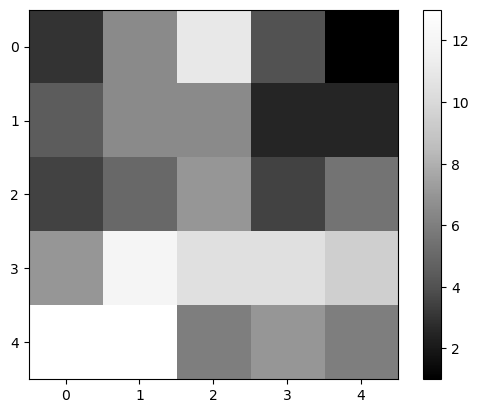

In [11]:
cle.imshow(result, colorbar=True)

With a quick visual check in the original image, we can see that indeed in the bottom left corner of the image, there are more cells than in the top right.

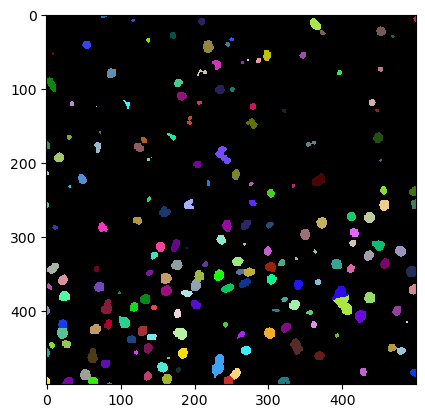

In [12]:
cle.imshow(cle.voronoi_otsu_labeling(image, spot_sigma=3.5), labels=True)

We can clean out the zarr data from the disk

In [13]:
# Check if the Zarr image exists
if os.path.exists(zarr_filename):
    # Delete the Zarr image directory and all its contents
    shutil.rmtree(zarr_filename)
    print(f"Zarr image '{zarr_filename}' and all its contents have been deleted.")
else:
    print(f"Zarr image '{zarr_filename}' does not exist.")

Zarr image './P1_H_C3H_M004_17-cropped.zarr' and all its contents have been deleted.


## Acknowledgement

This notebook is adapted from of the [BioImageAnalysisNotebook](https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/intro.html) of Robert Haase.

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.10465773.svg)](https://doi.org/10.5281/zenodo.10465773).